In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from skimage import io
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionV3, VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # resizing it to 128*128
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [ ]:
labels = ['real', 'fake']

X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Real
# 1 - Fake
image_path = "/content/drive/MyDrive/Image_forensics/dataset/" # path containing image samples

In [ ]:
for folder in os.scandir(image_path):
    for entry in os.scandir(image_path + folder.name):

        X.append(read_and_preprocess(image_path + folder.name + '/' + entry.name))

        if folder.name[0]=='r':
            y.append(0) # real
        else:
            y.append(1) # fake

In [ ]:
X = np.array(X)
X.shape # We have 1289 image samples in total

(3340, 128, 128, 3)

In [ ]:
y = np.array(y)
y.shape


(3340,)

<BarContainer object of 2 artists>

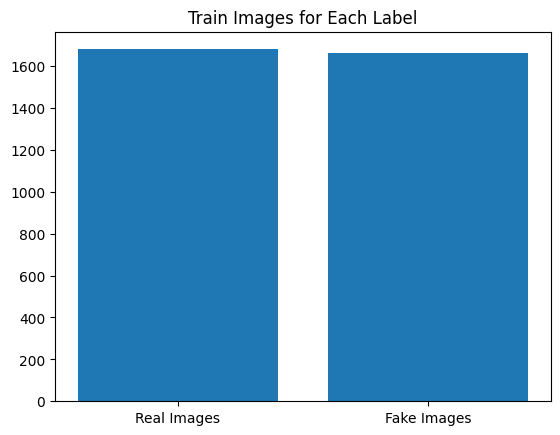

In [ ]:
real_count = len(y[y==0])
fake_count = len(y[y==1])

plt.title("Train Images for Each Label")
plt.bar(["Real Images", "Fake Images"],[real_count, fake_count])

# We have more samples of Fake Images than Real Images

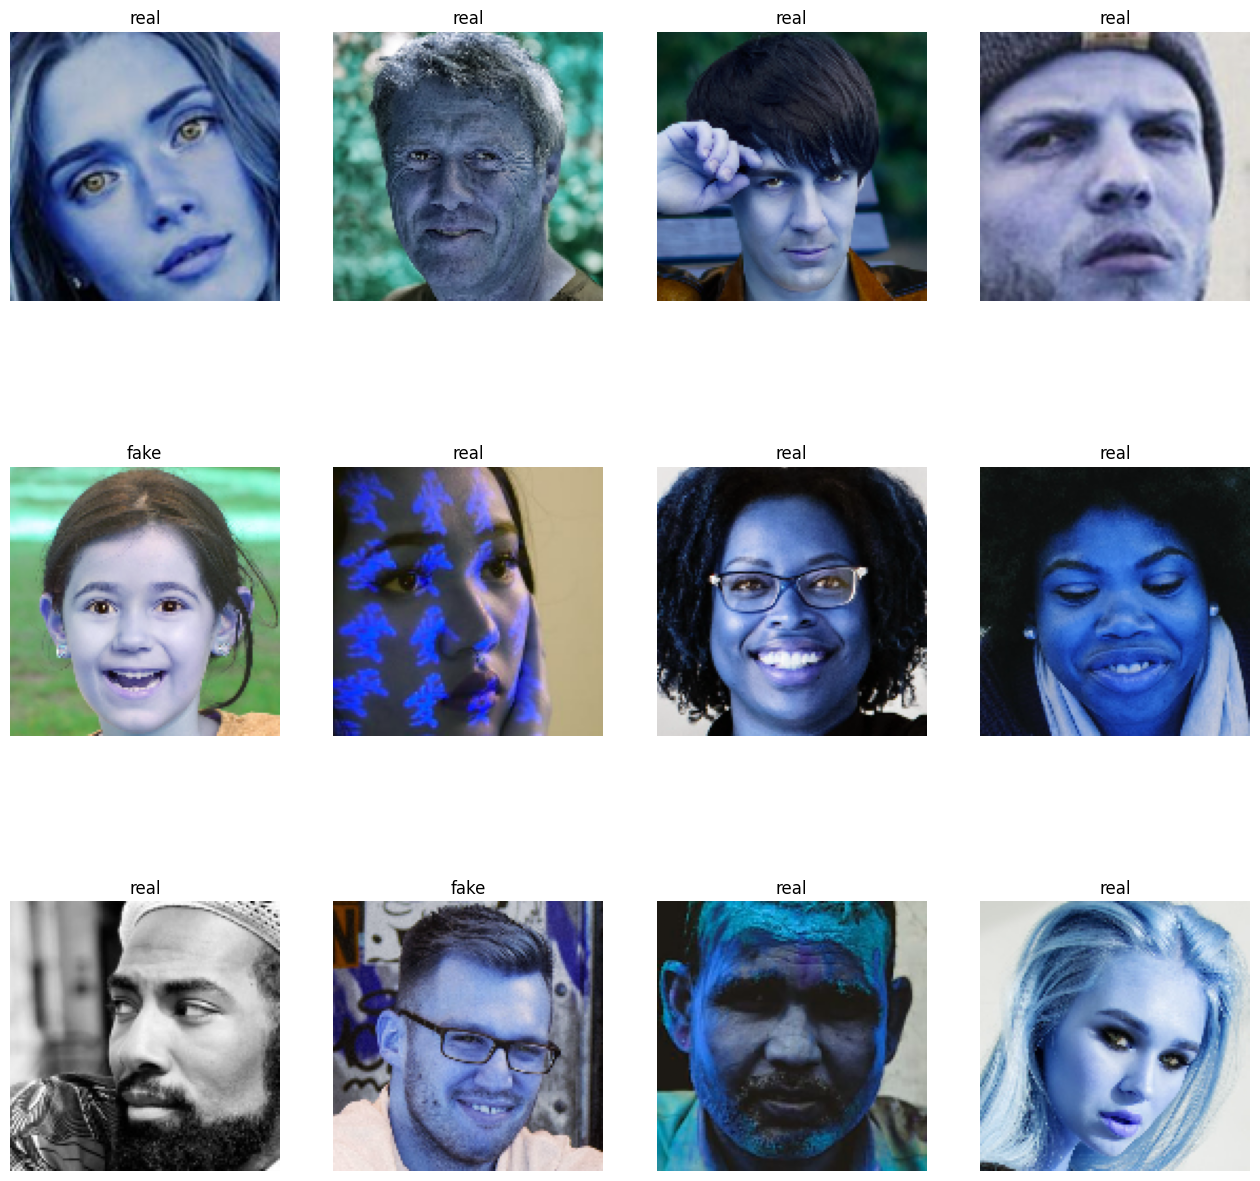

In [ ]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.axis("off")
    img_idx = random.randint(0, len(X) - 1)  # Randomly select an index
    plt.imshow(X[img_idx])
    plt.title(labels[y[img_idx]])  # Assuming labels is a list of class names


In [ ]:
from sklearn.model_selection import train_test_split

# We have splitted our data in a way that -
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=123)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val,
                                                  test_size=0.5,
                                                  shuffle=True,
                                                  stratify=y_val,
                                                  random_state=123)

In [ ]:
# we are using 1031 images for training our model
X_train.shape

(2672, 128, 128, 3)

In [ ]:
X_val.shape

(334, 128, 128, 3)

In [ ]:
X_test.shape

(334, 128, 128, 3)

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization

    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [ ]:
# There are 1.1 Million Traininable Parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        6

In [ ]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights.h5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

In [ ]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# Load pretrained model (best saved one)
with open("/content/drive/MyDrive/Image_forensics/fakevsreal_model.json", 'r') as json_file:
    json_savedModel= json_file.read()

# load the model weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights("/content/drive/MyDrive/Image_forensics/fakevsreal_weights.h5")
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [ ]:
# making predictions
predictions = model.predict(X_test)

11/11 [==============================] - 2s 165ms/step


In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.6646706586826348

<Axes: >

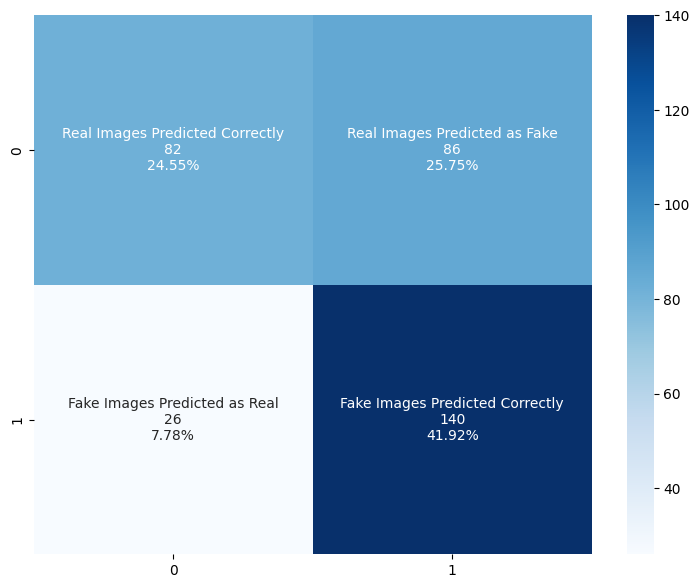

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize = (9,7))

group_names = ['Real Images Predicted Correctly','Real Images Predicted as Fake','Fake Images Predicted as Real','Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.49      0.59       168
           1       0.62      0.84      0.71       166

    accuracy                           0.66       334
   macro avg       0.69      0.67      0.65       334
weighted avg       0.69      0.66      0.65       334



In [ ]:
path = "/content/drive/MyDrive/Image_forensics/train"
real_path = path + "/real/"
fake_path = path + "/fake/"

real_img_files = os.listdir(real_path)
fake_img_files = os.listdir(fake_path)

In [ ]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image[...,::-1]

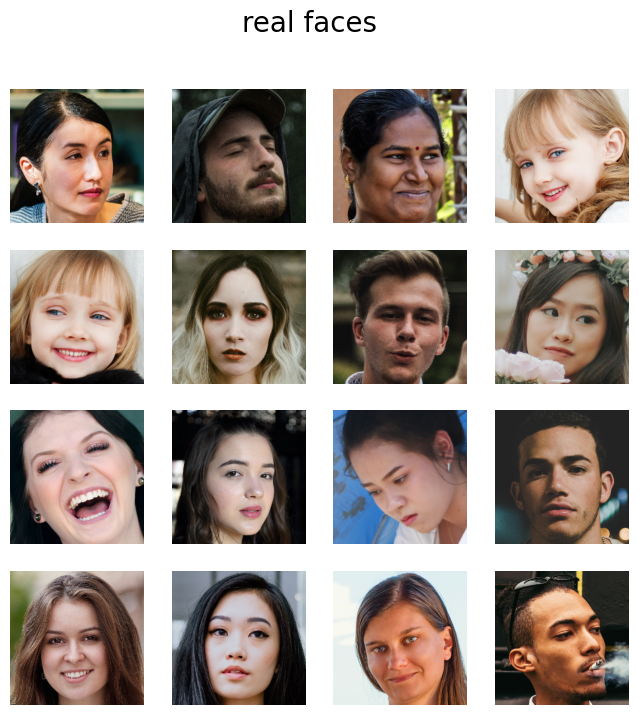

In [ ]:
fig = plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real_path + real_img_files[i]), cmap='gray')
    plt.axis('off')
plt.suptitle("real faces", fontsize=20)
plt.show()

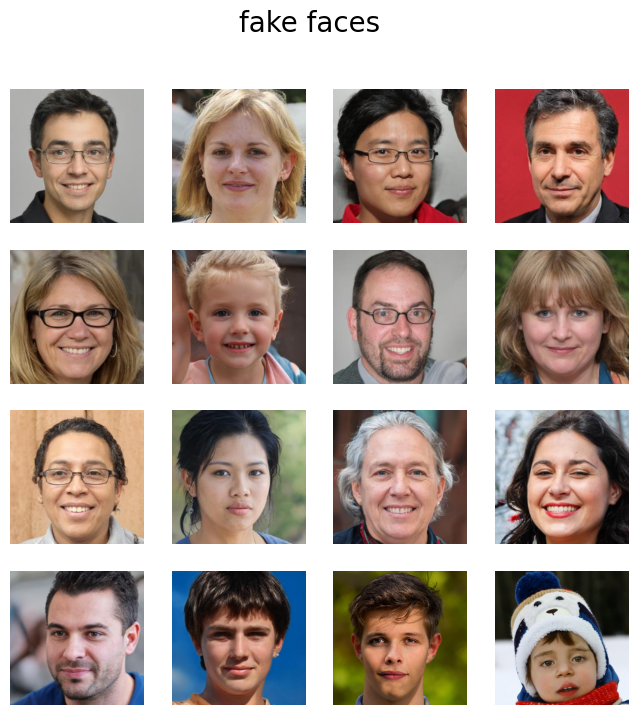

In [ ]:
fig = plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake_path + fake_img_files[i]), cmap='gray')
    plt.axis('off')
plt.suptitle("fake faces", fontsize=20)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90, rescale=1./255, )

In [ ]:
train_dataset = train_datagen.flow_from_directory(path, class_mode="binary", target_size=(224, 224), batch_size=32)

Found 2730 images belonging to 2 classes.


In [ ]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif 2 < epoch and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
mobilenetV2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

average_layer = GlobalAveragePooling2D()

model1 = Sequential([mobilenetV2,
                    average_layer,
                    Dense(256, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(1, activation="sigmoid")
                    ])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist1 = model1.fit(train_dataset, epochs=50, callbacks=[lr_callbacks])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist1.history['accuracy'])
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(hist1.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle("MobileNetV2 model - Accuracy & Loss")

plt.show()

In [ ]:
# saving the model and history
model1.save("/content/drive/MyDrive/Datasets/mobilenetV2 model.h5")
pd.DataFrame(hist1.history).to_csv("/content/drive/MyDrive/Datasets/history1")

In [ ]:
vgg16 = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

average_layer = GlobalAveragePooling2D()

model2 = Sequential([vgg16,
                    average_layer,
                    Dense(256, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(1, activation="sigmoid")
                    ])

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(train_dataset, epochs=50, callbacks=[lr_callbacks])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist2.history['accuracy'])
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(hist2.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle("VGG16 model - Accuracy & Loss")

plt.show()

In [ ]:
model2.save("/content/drive/MyDrive/Datasets/vgg16 model.h5")
pd.DataFrame(hist2.history).to_csv("/content/drive/MyDrive/Datasets/history2")

In [ ]:
inceptionv3 = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

average_layer = GlobalAveragePooling2D()

model3 = Sequential([inceptionv3,
                    average_layer,
                    Dense(256, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(1, activation="sigmoid")
                    ])

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist3 = model3.fit(train_dataset, epochs=50, callbacks=[lr_callbacks])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist3.history['accuracy'])
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(hist3.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle("InceptionV3 model - Accuracy & Loss")

plt.show()

In [ ]:
model3.save("/content/drive/MyDrive/Datasets/inceptionv3 model.h5")
pd.DataFrame(hist3.history).to_csv("/content/drive/MyDrive/Datasets/history3")

In [ ]:
vgg19 = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

average_layer = GlobalAveragePooling2D()

model4 = Sequential([vgg19,
                    average_layer,
                    Dense(512, activation="relu"),
                    BatchNormalization(),
                    Dense(256, activation="relu"),
                    Dense(128, activation="relu"),
                    Dense(64, activation="relu"),
                    Dropout(0.2),
                    Dense(1, activation="sigmoid")
                    ])

In [ ]:
model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist4 = model4.fit(train_dataset, epochs=50, callbacks=[lr_callbacks])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist4.history['accuracy'])
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(hist4.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle("VGG19 model - Accuracy & Loss")

plt.show()

In [ ]:
model4.save("/content/drive/MyDrive/Datasets/vgg19 model.h5")
pd.DataFrame(hist4.history).to_csv("/content/drive/MyDrive/Datasets/history4")

In [ ]:
model1_path = "/content/drive/MyDrive/Image_forensics/mobilenetV2 model.h5"
model2_path = "/content/drive/MyDrive/Image_forensics/vgg16 model.h5"
model3_path = "/content/drive/MyDrive/Image_forensics/inceptionv3 model.h5"
model4_path = "/content/drive/MyDrive/Image_forensics/vgg19 model.h5"

trained_model1 = tf.keras.models.load_model(model1_path)
trained_model2 = tf.keras.models.load_model(model2_path)
trained_model3 = tf.keras.models.load_model(model3_path)
trained_model4 = tf.keras.models.load_model(model4_path)

In [ ]:
trained_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [ ]:
trained_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
trained_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_94 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
trained_model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)              

In [ ]:
testing_path = "/content/drive/MyDrive/Image_forensics/test"
X_test = []
y_test = []
for folder in os.listdir(testing_path):
  targetpath = testing_path + '/' + folder
  for file in os.listdir(targetpath):
    if file.endswith('.jpg' ) or file.endswith('.png') or file.endswith('.jpeg'):
      img = io.imread(targetpath + '/' + file)
      img = resize(img,(224,224,3), anti_aliasing=True)
      img = np.array(img)
      X_test.append(img)

      if folder == "fake":
        y_test.append([0])
      else:
        y_test.append([1])

In [ ]:
len(X_test), len(y_test)

(600, 600)

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
testLoss1, testAccuracy1 = trained_model1.evaluate(X_test, y_test)
testLoss2, testAccuracy2 = trained_model2.evaluate(X_test, y_test)
testLoss3, testAccuracy3 = trained_model3.evaluate(X_test, y_test)
testLoss4, testAccuracy4 = trained_model4.evaluate(X_test, y_test)

19/19 [==============================] - 296s 15s/step - loss: 0.5076 - accuracy: 0.7217


In [ ]:
print("MODEL NAME".center(20), "TEST ACCURACY".center(15), "TEST LOSS".center(15))
print("MobileNetV2".ljust(20), ('%.4f'%testAccuracy1).rjust(10), " "*5, ('%.4f'%testLoss1).rjust(10))
print("VGG16".ljust(20),       ('%.4f'%testAccuracy2).rjust(10), " "*5, ('%.4f'%testLoss2).rjust(10))
print("InceptionV3".ljust(20), ('%.4f'%testAccuracy3).rjust(10), " "*5, ('%.4f'%testLoss3).rjust(10))
print("VGG19".ljust(20),       ('%.4f'%testAccuracy4).rjust(10), " "*5, ('%.4f'%testLoss4).rjust(10))

     MODEL NAME       TEST ACCURACY     TEST LOSS   
MobileNetV2              0.9833           0.0488
VGG16                    0.5150           0.6865
InceptionV3              0.9567           0.1097
VGG19                    0.7217           0.5076


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred1 = trained_model1.predict(X_test)
y_pred2 = trained_model2.predict(X_test)
y_pred3 = trained_model3.predict(X_test)
y_pred4 = trained_model4.predict(X_test)

19/19 [==============================] - 290s 15s/step


In [ ]:
def calculate_y(y):
  y_ = []
  for i in range(len(y)):
    y_.append(int(y[i][0] > 0.5))
  return np.array(y_)

In [ ]:
y_pred1 = calculate_y(y_pred1)
y_pred2 = calculate_y(y_pred2)
y_pred3 = calculate_y(y_pred3)
y_pred4 = calculate_y(y_pred4)

Confusion Matrix
[[291   9]
 [  1 299]]
Classification Report
              precision    recall  f1-score   support

        fake       1.00      0.97      0.98       300
        real       0.97      1.00      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



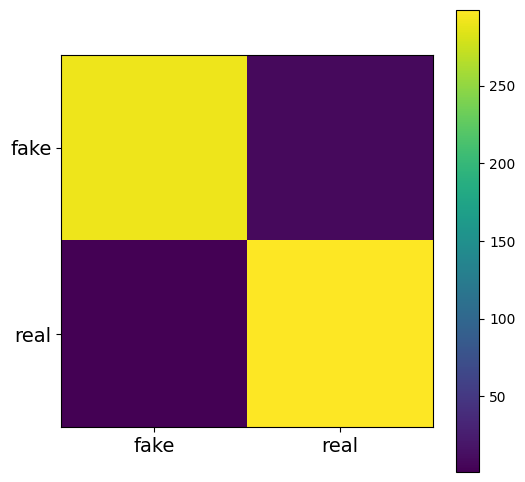

In [ ]:
cm_test = confusion_matrix(y_test, y_pred1)
print('Confusion Matrix')
print(cm_test)

print('Classification Report')
print(classification_report(y_test, y_pred1, target_names=['fake', 'real']))

plt.figure(figsize=(6,6))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(2)
_ = plt.xticks(tick_mark, ['fake', 'real'], fontsize="14")
_ = plt.yticks(tick_mark, ['fake', 'real'], fontsize="14")

Confusion Matrix
[[300   0]
 [291   9]]
Classification Report
              precision    recall  f1-score   support

        fake       0.51      1.00      0.67       300
        real       1.00      0.03      0.06       300

    accuracy                           0.52       600
   macro avg       0.75      0.52      0.37       600
weighted avg       0.75      0.52      0.37       600



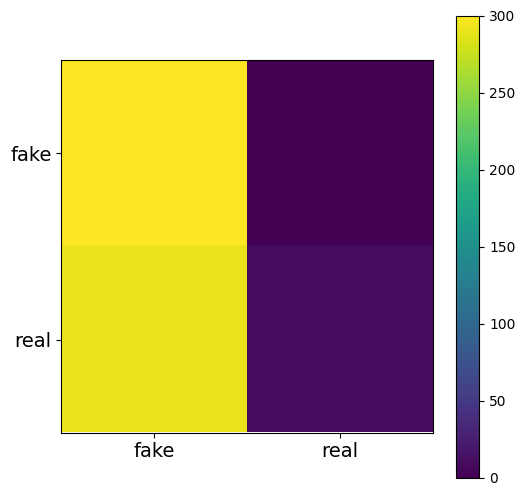

In [ ]:
cm_test = confusion_matrix(y_test, y_pred2)
print('Confusion Matrix')
print(cm_test)

print('Classification Report')
print(classification_report(y_test, y_pred2, target_names=['fake', 'real']))

plt.figure(figsize=(6,6))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(2)
_ = plt.xticks(tick_mark, ['fake', 'real'], fontsize="14")
_ = plt.yticks(tick_mark, ['fake', 'real'], fontsize="14")

Confusion Matrix
[[276  24]
 [  2 298]]
Classification Report
              precision    recall  f1-score   support

        fake       0.99      0.92      0.96       300
        real       0.93      0.99      0.96       300

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



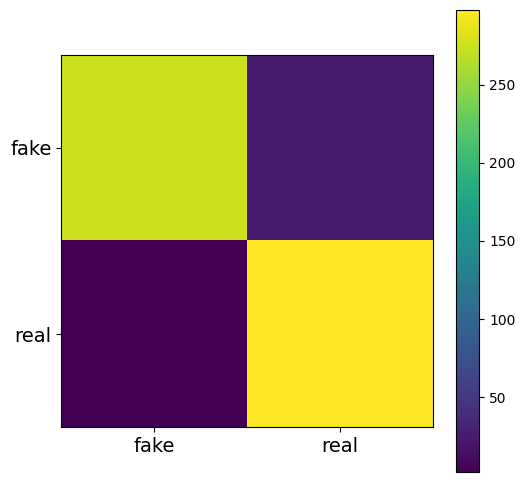

In [ ]:
cm_test = confusion_matrix(y_test, y_pred3)
print('Confusion Matrix')
print(cm_test)

print('Classification Report')
print(classification_report(y_test, y_pred3, target_names=['fake', 'real']))

plt.figure(figsize=(6,6))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(2)
_ = plt.xticks(tick_mark, ['fake', 'real'], fontsize="14")
_ = plt.yticks(tick_mark, ['fake', 'real'], fontsize="14")

Confusion Matrix
[[133 167]
 [  0 300]]
Classification Report
              precision    recall  f1-score   support

        fake       1.00      0.97      0.98       300
        real       0.97      1.00      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



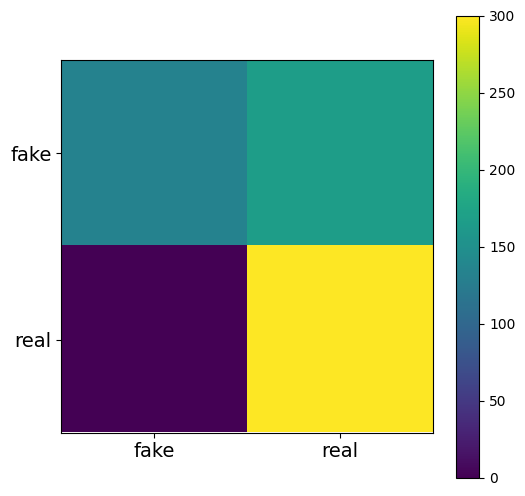

In [ ]:
cm_test = confusion_matrix(y_test, y_pred4)
print('Confusion Matrix')
print(cm_test)

print('Classification Report')
print(classification_report(y_test, y_pred1, target_names=['fake', 'real']))

plt.figure(figsize=(6,6))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(2)
_ = plt.xticks(tick_mark, ['fake', 'real'], fontsize="14")
_ = plt.yticks(tick_mark, ['fake', 'real'], fontsize="14")

In [ ]:
AI_image_path = "/content/drive/MyDrive/Image_forensics/AI images"
AI_images = []

for ai_img in os.listdir(AI_image_path):
  if ai_img.endswith('.jpg' ) or ai_img.endswith('.png') or ai_img.endswith('.jpeg'):
    img = io.imread(AI_image_path + '/' + ai_img)
    img = resize(img,(128,128,3), anti_aliasing=True)
    img = np.array(img)
    AI_images.append(img)

AI_images = np.array(AI_images)

In [ ]:
len(AI_images)

151

In [ ]:
y_value = np.array([[0]]*len(AI_images))

In [ ]:
testLoss1, testAccuracy1 = trained_model1.evaluate(AI_images, y_value)
testLoss2, testAccuracy2 = trained_model2.evaluate(AI_images, y_value)
testLoss3, testAccuracy3 = trained_model3.evaluate(AI_images, y_value)
testLoss4, testAccuracy4 = trained_model4.evaluate(AI_images, y_value)

5/5 [==============================] - 25s 5s/step - loss: 1220.0568 - accuracy: 0.0000e+00


In [ ]:
print("AI Generated Images Testing".center(70), "\n")
print("MODEL NAME".center(20), "TEST ACCURACY".center(15), "TEST LOSS".center(15))
print("MobileNetV2".ljust(20), ('%.4f'%testAccuracy1).rjust(10), " "*5, ('%.4f'%testLoss1).rjust(10))
print("VGG16".ljust(20),       ('%.4f'%testAccuracy2).rjust(10), " "*5, ('%.4f'%testLoss2).rjust(10))
print("InceptionV3".ljust(20), ('%.4f'%testAccuracy3).rjust(10), " "*5, ('%.4f'%testLoss3).rjust(10))
print("VGG19".ljust(20),       ('%.4f'%testAccuracy4).rjust(10), " "*5, ('%.4f'%testLoss4).rjust(10))

                     AI Generated Images Testing                       

     MODEL NAME       TEST ACCURACY     TEST LOSS   
MobileNetV2              0.9934           0.0573
VGG16                    1.0000           0.1123
InceptionV3              0.1325           2.7920
VGG19                    0.0000        1220.0568


1/1 [==============================] - 1s 1s/step

Model 1 :
[[0.74691457]]

Model 2 :
[[0.1440178]]

Model 3 :
[[0.7216017]]


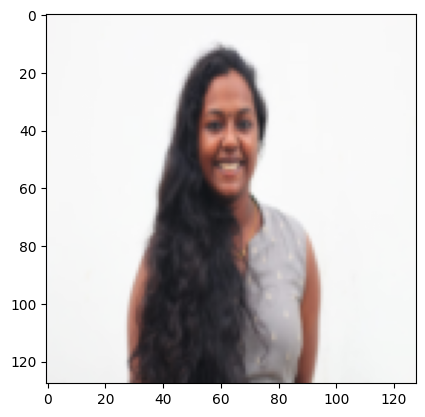

In [ ]:
# fake image
img_path = "/content/drive/MyDrive/Image_forensics/06fc8348-dc05-49fa-9300-de0f1a172388.JPG"
image = io.imread(img_path)
input_arr = resize(image, (128,128,3), anti_aliasing=True)
input_arr = np.array([input_arr])

plt.imshow(input_arr[0])

y_pred1 = trained_model1.predict(input_arr)
y_pred2 = trained_model2.predict(input_arr)
y_pred3 = trained_model3.predict(input_arr)

print("\nModel 1 :")
print(y_pred1)
'''
if y_pred1[0][0] > y_pred1[0][1]:
  print("it is fake")
else:
  print("it is real")
'''

print("\nModel 2 :")
print(y_pred2)

print("\nModel 3 :")
print(y_pred3)

1/1 [==============================] - 0s 45ms/step

Model 1 :
[[0.68561304]]

Model 2 :
[[0.1793671]]

Model 3 :
[[0.9516359]]


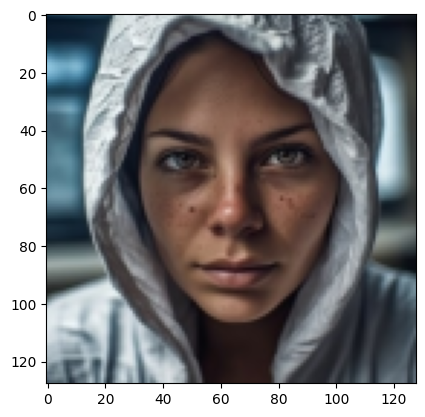

In [ ]:
# real image
img_path = "/content/drive/MyDrive/Image_forensics/Brazil.jpg"
image = io.imread(img_path)
input_arr = resize(image, (128,128,3), anti_aliasing=True)
input_arr = np.array([input_arr])

plt.imshow(input_arr[0])

y_pred1 = trained_model1.predict(input_arr)
y_pred2 = trained_model2.predict(input_arr)
y_pred3 = trained_model3.predict(input_arr)

print("\nModel 1 :")
print(y_pred1)

print("\nModel 2 :")
print(y_pred2)

print("\nModel 3 :")
print(y_pred3)

1/1 [==============================] - 0s 46ms/step

Model 1 :
[[0.97038937]]

Model 2 :
[[0.10248573]]

Model 3 :
[[0.885109]]


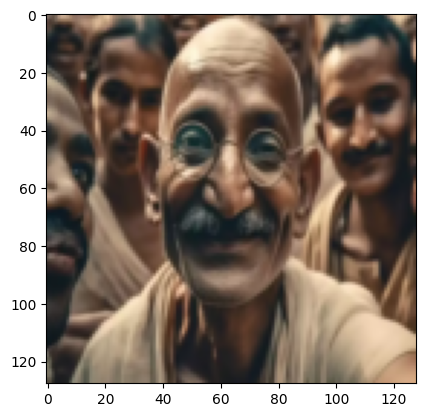

In [ ]:
# fake image
img_path = "/content/drive/MyDrive/Image_forensics/mahatma.jpg"
image = io.imread(img_path)
input_arr = resize(image, (128,128,3), anti_aliasing=True)
input_arr = np.array([input_arr])

plt.imshow(input_arr[0])

y_pred1 = trained_model1.predict(input_arr)
y_pred2 = trained_model2.predict(input_arr)
y_pred3 = trained_model3.predict(input_arr)

print("\nModel 1 :")
print(y_pred1)

print("\nModel 2 :")
print(y_pred2)

print("\nModel 3 :")
print(y_pred3)